## Imports and helper functions

In [20]:
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    T2IAdapter,
    MultiAdapter,
    StableDiffusionAdapterPipeline,
    DDPMScheduler
)

import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers.optimization import get_scheduler

In [21]:
from types import SimpleNamespace
from datasets import load_dataset

#Generate an arg list 

args = SimpleNamespace()

#Dataset generation args
args.dataset_name = "fusing/fill50k"
args.train_data_dir = None #"../ControlNet/training/fill50k"
args.dataset_config_name=None
args.cache_dir = None
args.image_column = "image"
args.caption_column = "text"
args.conditioning_image_column = "conditioning_image"
args.resolution = 512
args.max_train_samples = 1000
args.seed = None
args.train_batch_size = 4
args.dataloader_num_workers = 0

#Training args
args.num_train_epochs = 200
args.max_train_steps = 1000
args.gradient_accumulation_steps = 1
args.do_classifier_free_guidance= False
args.validation_steps = 1
args.set_grads_to_none = False
#learning rate
args.lr_scheduler = "constant"
args.lr_num_cycles = 1
args.lr_power = 1
args.lr_warmup_steps = 500
args.lr = 1e-5

#Validation args
args.seed = None

#adapter args
args.adapter_conditioning_scale = 1.0
args.num_images_per_prompt = 1

## Generate training dataset

### Generate base images first

(-0.5, 511.5, 511.5, -0.5)

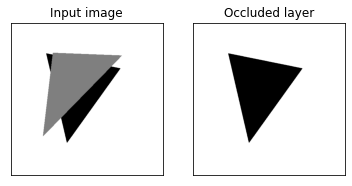

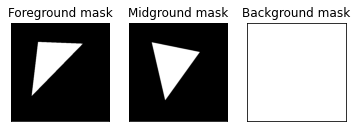

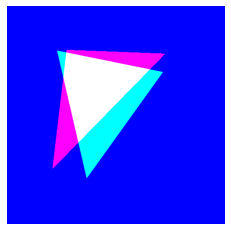

In [22]:
#Generate some generic training data real quick


import numpy as np 
import cv2
import matplotlib.pyplot as plt

def generate_triangle_sdf(H,W):
    
    EPS = 1e-12
    x_pos, y_pos = np.meshgrid(np.linspace(0, (H-1), H),np.linspace(0, (W-1), W))

    thresh = int(.2*W)
    len_thresh = thresh*2
    img_np = np.zeros((H, W), dtype=np.uint8)
    valid2 = False
    valid3 = False
    while valid2 == False or valid3 == False:
        x_1 = int(np.random.uniform(thresh,H-thresh))
        y_1 = int(np.random.uniform(thresh,W-thresh))

        #Compute a second point for the triangle
        x_2 = int(np.random.uniform(thresh,H-thresh))
        y_2 = int(np.random.uniform(thresh,W-thresh))
        idx = 0 
        while np.linalg.norm(np.array([x_1,y_1]) - np.array([x_2,y_2])) < len_thresh:
            if idx < 50:
                x_2 = int(np.random.uniform(thresh,H-thresh))
                y_2 = int(np.random.uniform(thresh,W-thresh))
                valid2 = True
            else:
                valid2 = False
                break

        x_3 = int(np.random.uniform(thresh,H-thresh))
        y_3 = int(np.random.uniform(thresh,W-thresh))
        idx = 0
        while (np.linalg.norm(np.array([x_1,y_1]) - np.array([x_3,y_3])) < len_thresh) or (np.linalg.norm(np.array([x_2,y_2]) - np.array([x_3,y_3])) < len_thresh):
            idx = idx +1
            if idx < 50:
                x_3 = int(np.random.uniform(thresh,H-thresh))
                y_3 = int(np.random.uniform(thresh,W-thresh)) 
                valid3 = True
            else:
                valid3 = False
                break
    
    pts_inp = np.array([[x_1, y_1], [x_2, y_2], [x_3, y_3]])
    
    oop_normal = [0,0,1]
    
    n = np.cross([x_1-x_2,y_1-y_2,0], [x_3-x_2,y_3-y_2])
    
    if np.dot(n,oop_normal) < 0:
        pts_inp = pts_inp[[0,2,1],:]
        x_2,y_2 = pts_inp[1,:]
        x_3,y_3 = pts_inp[2,:]
        
    normals = []
    ix_12 = np.linspace(x_1,x_2,500)
    m_12 = (y_2-y_1)/(x_2-x_1 + EPS)
    iy_12 = y_2 + m_12*(ix_12 - x_2)
    out_12 =  np.array([[x, y] for (x, y) in zip(ix_12, iy_12)])
    norm_12 = [np.arctan2(y_2-y_1, x_2-x_1)+np.pi/2] * len(ix_12)
    normals.extend(norm_12)
    
    ix_23 = np.linspace(x_2,x_3,500)
    m_23 = (y_3-y_2)/(x_3-x_2 + EPS)
    iy_23 = y_3 + m_23*(ix_23 - x_3)
    out_23 =  np.array([[x, y] for (x, y) in zip(ix_23, iy_23)])
    norm_23 = [np.arctan2(y_3-y_2, x_3-x_2)+np.pi/2] * len(ix_23)
    normals.extend(norm_23)
    
    ix_31 = np.linspace(x_3,x_1,500)
    m_31 = (y_1-y_3)/(x_1-x_3 + EPS)
    iy_31 = y_1 + m_31*(ix_31 - x_1)
    out_31 =  np.array([[x, y] for (x, y) in zip(ix_31, iy_31)])
    norm_31 = [np.arctan2(y_1-y_3, x_1-x_3)+np.pi/2] * len(ix_31)
    normals.extend(norm_31)
    
    #Combine all 3 ouputs
    out_pts = np.concatenate([out_12,out_23,out_31],axis=0)
    out_pts = out_pts.reshape((1, -1, 2))

    
    pts = pts_inp.reshape((1,-1,2))
    cv2.fillPoly(img_np, pts, color=255, lineType=cv2.LINE_AA)
    img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
    img = np.asarray(img/255.0,dtype=np.float32)
    img = np.asarray(img>.5,dtype=np.float32)
    normals = np.asarray(normals)
    
    return img, out_pts, normals

H=W=512

plt.figure()
plt.subplot(122)
img,out_pts,normals = generate_triangle_sdf(H,W)
img = 1 - img
first_img = (np.repeat(img,3,-1)* 255).astype(np.uint8)
plt.imshow(first_img)
plt.xticks([]); plt.yticks([])
mask_img,_,_ = generate_triangle_sdf(H,W)
mask_img = mask_img[:,:,0].astype(int)
plt.title('Occluded layer')

masked_img = np.copy(img)
masked_img[mask_img==1] = .5


plt.subplot(121)
plt.imshow((np.repeat(masked_img,3,-1)* 255).astype(np.uint8),cmap='gray_r')
plt.xticks([]); plt.yticks([])
plt.title('Input image')

plt.figure()
plt.subplot(131)
fg_layer = mask_img
plt.imshow(fg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);
plt.title('Foreground mask')

plt.subplot(132)
mid_layer = (1-img).squeeze()
plt.imshow(mid_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);
plt.title('Midground mask')

plt.subplot(133)
bg_layer = np.ones(mid_layer.shape)
plt.imshow(bg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);
plt.title('Background mask')

plt.figure()
layer_img = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)
plt.imshow(layer_img)
plt.axis('off')

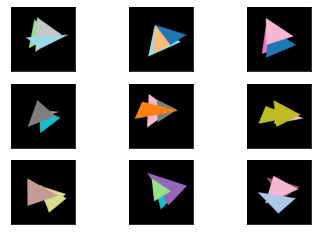

In [23]:
#Generate some generic training data real quick

import numpy as np 
import cv2
import matplotlib.pyplot as plt

def create_polygon(center, min_radius, max_radius, color, H=H,W=W):
    num_sides = 3# np.random.randint(6, 10)  # Random number of sides between 3 and 10
    angles = [np.random.randn()/8 + .5 for _ in range(num_sides)]
    angles = angles /  np.sum(angles) * np.pi *2
    angles = np.cumsum(angles)
    
    
    # Generate random radii for the vertices
    radii = [np.random.uniform(min_radius, max_radius) for _ in range(num_sides)]

    # Calculate the vertex coordinates
    vertices = []
    for i in range(num_sides):
        angle = angles[i]  #
        radius = radii[i]
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        vertices.append((x, y))

    # Close the polygon by connecting the last vertex to the first vertex
    vertices.append(vertices[0])
    
    mask = np.zeros((H, W,1), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(vertices, dtype=np.int32)], 255)

    
    poly_img = np.zeros((H, W,3), dtype=np.uint8)
    cv2.fillPoly(poly_img, [np.array(vertices, dtype=np.int32)], color)
    return vertices, mask, poly_img


def generate_overlapping_polygons(H,W,num_polygons = 3):
    
    img_np = np.zeros((H, W,3), dtype=np.uint8)
    
    # Get the matplotlib colormap
    colormap = plt.get_cmap("tab20")
    polygons = []
    masks = []

    for _ in range(num_polygons):
        center_point = (np.random.uniform(H*.4,H*.6), np.random.uniform(W*.4,W*.6))
        minimum_radius = np.random.uniform(H*.15, H*.2)
        maximum_radius = np.random.uniform(H*.3, H*.4)

        # Generate a random color index within the colormap range
        color_index = np.random.randint(0, 20)
        color = colormap(color_index)

        # Convert the color from the range [0, 1] to [0, 255]
        color = tuple(int(c * 255) for c in color)
        # Convert the vertices to an array of integers
        vertices, mask,polygon =  create_polygon(center_point, minimum_radius, maximum_radius,color)
        vertices_int = np.array(vertices, dtype=np.int32)

        # Draw the filled polygon on the canvas
        cv2.fillPoly(img_np, [vertices_int], color)
        
        polygons.append(polygon)
        masks.append(mask)

    img = img_np.reshape(img_np.shape[0],img_np.shape[1],3)
    img = np.asarray(img/255.0,dtype=np.float32)
    # img = np.asarray(img>.5,dtype=np.float32)
    
    masks.reverse()
    polygons.reverse()
    
    return img, masks, polygons

for itr in range(9):
    plt.subplot(3,3,itr+1)
    img, masks, polygons = generate_overlapping_polygons(H,W,3)
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img)

In [24]:
def combine_masks(binary_masks, index):
    '''
    input: binary_masks, size B x Layers x C x H x W
    '''
    
    combined_list = []
    for batch_id in range(binary_masks.shape[0]):
        combined_mask = torch.zeros_like(binary_masks[0,0,...], dtype=torch.uint8)
        for i in range(index):
            combined_mask = torch.logical_or(combined_mask, binary_masks[batch_id,i,...])
        combined_list.append(combined_mask)
    return torch.stack(combined_list)


# combined_mask = combine_masks(torch.tensor(masks).squeeze().unsqueeze(0),2)

# plt.imshow(combined_mask.squeeze(),cmap='gray')

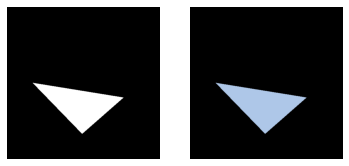

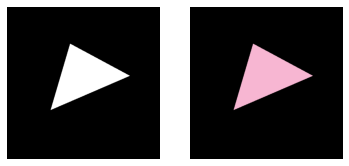

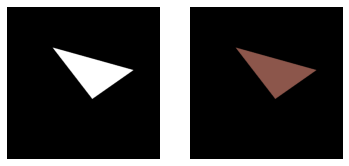

In [25]:
for mask,polygon in zip(masks,polygons):
    plt.figure()
    plt.subplot(121)
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(polygon)
    plt.axis('off')

In [ ]:
DATASET_SIZE=1000
H=W=512

layer_binaries = []
layer_imgs = []
base_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(DATASET_SIZE):
    img, masks, polygons = generate_overlapping_polygons(H,W,3)
    
    #add to lists
    layer_binaries.append(gray2rgb(masks))
    layer_imgs.append(polygons)
    base_imgs.append(img)
    
    if itr%200 == 0:
        print(itr)
    

0
200
400
600


In [ ]:
# # Also need to generate some utils for the training for the layering maps
# # For example need some code that combines all layer maps below a layer and all above a layer
# # Also need analagous code that does this for the layered  objects in the image

# def get_front_layers(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) -1 #subtract 1 for loops??
#     front_layers = np.ones(layer_imgs[0].shape)
#     front_bin = np.zeros(layer_bin.shape)
#     if layer_no == num_layers:
#         return front_layers,front_bin
#     else:
#         for layer_idx in range(layer_no,num_layers):
#             front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#             front_bin[layer_bin==1] = 1
#         return front_layers,front_bin
        

# def get_back_layer(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) - 1
#     back_layers = np.ones(layer_imgs[0].shape)
#     back_bin = np.zeros(layer_bin.shape)
#     for layer_idx in range(layer_no):
#         #FINISH / FIX THIS CODE AT SOMEPOINT
#         front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#         front_bin[layer_bin==1] = 1
#     return front_layers,front_bin

### Put data into dataset objects

In [ ]:
#Define image transforms

image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

conditioning_image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
    ]
)

In [ ]:
# Create a dataset class
class LayerDataset(Dataset):
    def __init__(self,base_imgs,layer_imgs,layer_binaries):
        self.data = list(zip(base_imgs,layer_imgs,layer_binaries))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = 'an object on a black background'

        source = item[0]
        targets = item[1]
        masks = item[2]
        
        #Convert to torch tensors and apply image transforms
        source = torch.tensor(source).permute(2,0,1)
        source = conditioning_image_transforms(source)

        target_list = []
        for target in targets:
            target_list.append(image_transforms(255*torch.tensor(target).permute(2,0,1)))
        target_tensor = torch.stack(target_list)
        
        mask_list = []
        for mask in masks:
            mask_list.append(conditioning_image_transforms(255*torch.tensor(mask).permute(2,0,1)))
        mask_tensor = torch.stack(mask_list)

        return dict(pixel_values=target_tensor, pixel_binaries =mask_tensor,  txt=prompt, conditioning_pixel_values=source)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    pixel_binaries = torch.stack([example["pixel_binaries"] for example in examples])
    pixel_binaries = pixel_binaries.to(memory_format=torch.contiguous_format).float()
    # input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "pixel_binaries": pixel_binaries,
        # "input_ids": input_ids,
    }


In [ ]:
train_dataset =  LayerDataset(base_imgs,layer_imgs,layer_binaries)

# plt.subplot(121)
# plt.imshow(train_dataset[0]['pixel_values'].permute(1,2,0)/ 2 + 1/2)

# plt.subplot(122)
# plt.imshow(train_dataset[0]['conditioning_pixel_values'].permute(1,2,0))

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

### Create a subset of validation images

In [ ]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(VALIDATION_SIZE):
    img, masks, polygons = generate_overlapping_polygons(H,W,3)
    
    #add to lists
    val_binaries.append(gray2rgb(masks))
    val_layers.append(polygons)
    val_imgs.append(img)
    
#     if itr%200 == 0:
#         print(itr)

In [ ]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    rint = np.random.randint(0,3)
    val_imgs_PIL.append([Image.fromarray((val_imgs[idx]*255).astype(np.uint8)), Image.fromarray((val_binaries[idx][rint]*255).astype(np.uint8))])
    val_layers_PIL.append(Image.fromarray(val_layers[idx][rint].astype(np.uint8)))
    
transform = transforms.Compose([transforms.PILToTensor()])
val_set = []
for imgs in val_imgs_PIL:
    # val_set.append(imgs)
    val_set.append(torch.cat([transform(img) for img in imgs],dim=0).unsqueeze(0))
    
args.validation_image = val_set
args.validation_prompt = ["picture of an object on a black background"]
args.num_validation_images = VALIDATION_SIZE

In [ ]:
## Hard code some things for getting the first layer of each val_layers for now

plt.subplot(221)
plt.imshow(val_imgs_PIL[0][0])
plt.xticks([]);plt.yticks([]);

plt.subplot(222)
plt.imshow(val_layers_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(223)
plt.imshow(val_imgs_PIL[1][0])
plt.xticks([]);plt.yticks([]);

plt.subplot(224)
plt.imshow(val_layers_PIL[1])
plt.xticks([]);plt.yticks([]);

In [ ]:
# conditioning_image_transforms(np.array(val_imgs_PIL[0]))

## Implement the adapter models

In [ ]:
import torch
import torch.nn as nn

## Network that takes 4 dimensional input and pushes it to 3 dimensions for the vae
class ContractNet(nn.Module):
    def __init__(self):
        super(ContractNet, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

    

## Network that takes 3 dimensional input and pushes it to 4 dimensions for model out
class ExpandNet(nn.Module):
    def __init__(self):
        super(ExpandNet, self).__init__()
        self.conv = nn.Conv2d(3, 4, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
#Instantiate the two adapters and the pretrained model

# An adapter that takes in the original image (or a subset of layers)
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter
adapter = MultiAdapter([RGB_adapter,mask_adapter])
# adapter = RGB_adapter

#Instantiate the Convolutional layers
# contract_layer = ContractNet()
# expand_layer = ExpandNet()

#Pretrained stable diffusion model that we will try not to touch (may end up changing the final conv_out though.
#To be honest I am really hoping this works

model_name = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionAdapterPipeline.from_pretrained(model_name, torch_dtype=torch.float32).to('cuda')
pipe.safety_checker = None

vae = pipe.vae
unet = pipe.unet
noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

## Not sure, do i turn off gradients for these networks? Probaly not in my optinion
# vae.requires_grad_(False)
# unet.requires_grad_(False)
# text_encoder.requires_grad_(False)
# also get the clip model because it matters probably....

#But looks like it may not work as just the model for training so we have to separate it into parts for training anyway

In [ ]:
#Random point, what if I dont do anything about the masking etc, and just try and make a model that removes the top object in a scene, or like just tries to get the layer mappings?

## Train the model

### TODO: Write a validation loop

In [ ]:
def log_validation(pipe, adapter, args, step=0,accelerator=None):
    print(f"step = {step}")

    # controlnet = accelerator.unwrap_model(controlnet)

    pipe.adapter = adapter
    # pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    # pipeline = pipeline.to(accelerator.device)
    # pipeline.set_progress_bar_config(disable=True)

#     if args.enable_xformers_memory_efficient_attention:
#         pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if len(args.validation_image) == len(args.validation_prompt):
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt
    elif len(args.validation_image) == 1:
        validation_images = args.validation_image * len(args.validation_prompt)
        validation_prompts = args.validation_prompt
    elif len(args.validation_prompt) == 1:
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt * len(args.validation_image)
    else:
        raise ValueError(
            "number of `args.validation_image` and `args.validation_prompt` should be checked in `parse_args`"
        )

    image_logs = []

    for validation_prompt, validation_image in zip(validation_prompts, validation_images):
        # validation_image = Image.open(validation_image).convert("RGB")

        images = []

        for _ in range(args.num_validation_images):
            print(validation_image.shape)
            # print([preprocess(img) for img in validation_image.unsqueeze(0)][0].shape)
            with torch.autocast("cuda"):
                image = pipe(
                    validation_prompt, validation_image, num_inference_steps=20, generator=generator,adapter_conditioning_scale = [1.0,0.0]
                ).images[0]

            images.append(image)

        image_logs.append(
            {"validation_image": validation_image, "images": images, "validation_prompt": validation_prompt}
        )
    return image_logs

# Here I need to make a set of images 
# Looks like top row, validation image *2, next validation image *2, bottom row is outputs

def save_image_logs(image_logs,step=0):
    plt.figure()
    plt.subplot(241)
    plt.imshow(image_logs[0]['validation_image'][0,:3,...].permute(1,2,0))
    plt.subplot(242)
    plt.imshow(image_logs[0]['validation_image'][0,:3,...].permute(1,2,0))
    plt.subplot(243)
    plt.imshow(image_logs[1]['validation_image'][0,:3,...].permute(1,2,0))
    plt.subplot(244)
    plt.imshow(image_logs[1]['validation_image'][0,:3,...].permute(1,2,0))

    plt.subplot(245)
    plt.imshow(image_logs[0]['images'][0])
    plt.subplot(246)
    plt.imshow(image_logs[0]['images'][1])
    plt.subplot(247)
    plt.imshow(image_logs[1]['images'][0])
    plt.subplot(248)
    plt.imshow(image_logs[1]['images'][1])

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

    plt.savefig(f'test_logs/v2_3_layer_training_epoch_{step}_val.png')

In [ ]:
log_validation(pipe, adapter, args)

### Actual training loop

In [ ]:
from src.diffusers.models.modeling_utils import ModelMixin
from typing import List, Optional

class MultiAdapter(ModelMixin):
    r"""
    MultiAdapter is a wrapper model that contains multiple adapter models and merges their outputs according to
    user-assigned weighting.

    This model inherits from [`ModelMixin`]. Check the superclass documentation for the generic methods the library
    implements for all the model (such as downloading or saving, etc.)

    Parameters:
        adapters (`List[T2IAdapter]`, *optional*, defaults to None):
            A list of `T2IAdapter` model instances.
    """

    def __init__(self, adapters: List[T2IAdapter]):
        super(MultiAdapter, self).__init__()

        self.num_adapter = len(adapters)
        self.adapters = nn.ModuleList(adapters)

    def forward(self, xs: torch.Tensor, adapter_weights: Optional[List[float]] = None) -> List[torch.Tensor]:
        r"""
        Args:
            xs (`torch.Tensor`):
                (batch, channel, height, width) input images for multiple adapter models concated along dimension 1,
                `channel` should equal to `num_adapter` * "number of channel of image".
            adapter_weights (`List[float]`, *optional*, defaults to None):
                List of floats representing the weight which will be multiply to each adapter's output before adding
                them together.
        """
        if adapter_weights is None:
            adapter_weights = torch.tensor([1 / self.num_adapter] * self.num_adapter)
        else:
            adapter_weights = torch.tensor(adapter_weights)

        if xs.shape[1] % self.num_adapter != 0:
            raise ValueError(
                f"Expecting multi-adapter's input have number of channel that cab be evenly divisible "
                f"by num_adapter: {xs.shape[1]} % {self.num_adapter} != 0"
            )
        x_list = torch.chunk(xs, self.num_adapter, dim=1)
        accume_state = None
        for x, w, adapter in zip(x_list, adapter_weights, self.adapters):
            features = adapter(x)
            if accume_state is None:
                accume_state = features
            else:
                for i in range(len(features)):
                    accume_state[i] = accume_state[i] + w * features[i]
        return accume_state


In [ ]:
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter

adapter = MultiAdapter([RGB_adapter,mask_adapter])
# adapters = [RGB_adapter,mask_adapter]

# adapter = RGB_adapter

In [ ]:
#Put adapter on GPU
# for adapter in adapters:
adapter = adapter.to("cuda")
adapter.train()

#Set optimizer class
optimizer_class = torch.optim.AdamW

#Get parameters to optimize
# params_to_optimize = list(adapters[0].parameters()) + list(adapters[1].parameters())
params_to_optimize = adapter.parameters()
optimizer = optimizer_class(
    params_to_optimize,
    lr = args.lr
) 

#Get lr scheduler = 
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,# * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps,# * args.gradient_accumulation_steps,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# additional, try to figure out accelerator

In [ ]:
vae.requires_grad_(False);
# unet.requires_grad_(False);

In [ ]:
## https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet.py
#Set number of max train steps?
torch.autograd.set_detect_anomaly(True)
args.max_train_steps = args.num_train_epochs * len(train_dataloader)


# Train!
total_batch_size = args.train_batch_size #* accelerator.num_processes * args.gradient_accumulation_steps

print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num batches each epoch = {len(train_dataloader)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Instantaneous batch size per device = {args.train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    # disable=not accelerator.is_local_main_process,
)

weight_dtype = torch.float32
image_logs = None
for epoch in range(first_epoch, args.num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        #### Convert images to latent space
        #network that goes from four to three dimensions
        
        # For each batch, we have to get a random layer
        # Generate mask and find polygon for that layer
        #Batch['pixel_values'] will correspond to the polygon for that layer
        rlayer = np.random.randint(0,3)
        
        latents = vae.encode(batch["pixel_values"][:,rlayer,:].squeeze().to(dtype=weight_dtype).to('cuda')).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        # print('Latents calculated')
        
        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        #Following two lines are for uneven sampling (see t2i section 3.4)
        timesteps = (1 - (timesteps/ noise_scheduler.config.num_train_timesteps)**3) *  noise_scheduler.config.num_train_timesteps
        timesteps = timesteps.to(torch.int).clip(0,noise_scheduler.config.num_train_timesteps-1).to(latents.device).long()
        # print(timesteps)
        # timesteps = timesteps.long()
        # print('Noise Generated')

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        prompt_embeds = pipe._encode_prompt(
            "picture of an object on a white background",
            device="cuda",
            num_images_per_prompt = args.train_batch_size ,
            do_classifier_free_guidance=args.do_classifier_free_guidance,
            negative_prompt=None,
            prompt_embeds=None,
            negative_prompt_embeds=None,
        )
        # print('Prompt Embeddings Generated')

        # Denoising loop
        #We will have two inputs into the adapter, batch{'conditioning_pixel_values'} corresponds to the ground truth image (unchanged)
        layer_masks = combine_masks(batch['pixel_binaries'],rlayer).clone()
        adapter_input = torch.cat([batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda').clone(), layer_masks.to(dtype=weight_dtype).to('cuda')],dim=1)
        adapter_state = adapter(adapter_input,[1.0,0.0])
        
        # adapter_inputs = [batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda'), 
        #                   layer_masks.to(dtype=weight_dtype).to('cuda')]
        # adapter_state = None
        # for x, adapter in zip(adapter_inputs, adapters):
        #     features = adapter(x)
        #     if adapter_state is None:
        #         adapter_state = features
        #     else:
        #         for i in range(len(features)):
        #             adapter_state[i] + adapter_state[i]+  .5 * features[i]
        
        
        for k, v in enumerate(adapter_state):
            adapter_state[k] = v * args.adapter_conditioning_scale
        if args.num_images_per_prompt > 1:
            for k, v in enumerate(adapter_state):
                adapter_state[k] = v.repeat(args.num_images_per_prompt, 1, 1, 1)
        if args.do_classifier_free_guidance:
            for k, v in enumerate(adapter_state):
                adapter_state[k] = torch.cat([v] * 2, dim=0)
        # print('Adapter values Generated')

        
        ## expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([noisy_latents] * 2) if args.do_classifier_free_guidance else noisy_latents

        # predict the noise residual
        noise_pred = unet(
                latent_model_input,
                timesteps,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
                down_block_additional_residuals=[state.clone() for state in adapter_state],
        ).sample

        # print('Prediction complete')
        # Get the target for loss depending on the prediction type
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
        loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
        # print('loss computed')
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none=args.set_grads_to_none)
        progress_bar.update(1)

    logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
    print(logs)
    
    progress_bar.set_postfix(**logs)
    if epoch % 1 == 0:
        val_out = log_validation(pipe, adapter, args)
        save_image_logs(val_out,step=epoch)
    if global_step >= args.max_train_steps:
        break

***** Running training *****
  Num examples = 1000
  Num batches each epoch = 250
  Num Epochs = 200
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 50000


Steps:   0%|          | 0/50000 [00:00<?, ?it/s]

{'loss': 0.0029526110738515854, 'lr': 1e-05}
step = 0
torch.Size([1, 6, 512, 512])


/n/home07/adamaraju/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_adapter.py:698: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0032385806553065777, 'lr': 1e-05}
step = 0
torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 6, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

In [74]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(VALIDATION_SIZE):
    
    #add to lists
    val_binaries.append(masks)
    val_layers.append(polygons)
    val_imgs.append(img)
    
#     if itr%200 == 0:
#         print(itr)

In [ ]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    val_imgs_PIL.append(Image.fromarray((val_imgs[idx]*255).astype(np.uint8)))
    val_layers_PIL.append(Image.fromarray(val_layers[idx][1].astype(np.uint8)))

args.validation_image = val_imgs_PIL
args.validation_prompt = ["picture of an object on a white background"]
args.num_validation_images = VALIDATION_SIZE

In [113]:
img, masks, polygons = generate_overlapping_polygons(H,W,2)
val_img = Image.fromarray((img*255).astype(np.uint8))

In [114]:
with torch.autocast("cuda"):
    image = pipe(args.validation_prompt, val_img, num_inference_steps=40, generator=None).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

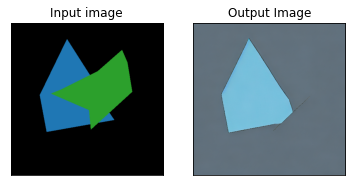

In [115]:
plt.subplot(121)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.title('Input image')

plt.subplot(122)
plt.imshow(image)
plt.title('Output Image')
plt.xticks([]); plt.yticks([]);